In [2]:
import math
import argparse
import ruamel.yaml as yaml
import umap
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import AutoTokenizer
from tqdm.notebook import tqdm, trange
import pickle
from sklearn.manifold import TSNE
from torch.utils.data import TensorDataset, DataLoader, Dataset

from src.models.model_diff_modular import ModularDiffModel
from src.adv_attack import get_hidden_dataloader
from src.utils import get_num_labels, dict_to_device
from src.data_handler import get_data_loader_bios


In [3]:
def get_data_sorted(args_train):
    num_labels = get_num_labels(args_train.labels_task_path)
    num_labels_protected = get_num_labels(args_train.labels_protected_path)
    tokenizer = AutoTokenizer.from_pretrained(args_train.model_name)
    train_loader = get_data_loader_bios(
        tokenizer = tokenizer,
        data_path = args_train.train_pkl,
        labels_task_path = args_train.labels_task_path,
        labels_prot_path = args_train.labels_protected_path,
        batch_size = args_train.batch_size,
        max_length = 200,
        shuffle = False,
        debug = False
    )
    val_loader = get_data_loader_bios(
        tokenizer = tokenizer,
        data_path = args_train.val_pkl,
        labels_task_path = args_train.labels_task_path,
        labels_prot_path = args_train.labels_protected_path,
        batch_size = args_train.batch_size,
        max_length = 200,
        shuffle = False,
        debug = False
    )
    with open(args_train.train_pkl, 'rb') as file:
        data_dicts_train = pickle.load(file)
    with open(args_train.val_pkl, 'rb') as file:
        data_dicts_val = pickle.load(file)
    return train_loader, val_loader, num_labels, num_labels_protected, data_dicts_train, data_dicts_val

def get_embeddings(model, loader):
        model.eval()
        emb_list = []
        label_list_task = []
        label_list_prot = []
        for batch in tqdm(loader, desc="generating embeddings"):
            inputs, labels_task, labels_prot = batch
            inputs = dict_to_device(inputs, model.device)
            hidden = model._forward(**inputs)
            emb_list.append(hidden.cpu())
            label_list_task.append(labels_task)
            label_list_prot.append(labels_prot)
        return torch.cat(emb_list), torch.cat(label_list_task), torch.cat(label_list_prot)

In [4]:
cp_dir = "/share/rk1/home/lukash/sparse_transformers/checkpoints_bios_seed1"
cp = "bert_uncased_L-4_H-256_A-4-fixmask0.1-modular-sparse_task-merged_head.pt"

In [5]:
with open("cfg.yml", "r") as f:
    cfg = yaml.safe_load(f)
args_train = argparse.Namespace(**cfg["train_config_diff_pruning"], **cfg["data_config_bios"], **cfg["model_config"])

In [6]:
model_biased = ModularDiffModel.load_checkpoint(f"{cp_dir}/{cp}", remove_parametrizations=True, debiased=False)
model_debiased = ModularDiffModel.load_checkpoint(f"{cp_dir}/{cp}", remove_parametrizations=True, debiased=True)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing B

In [7]:
setattr(args_train, "train_pkl", "/share/cp/datasets/nlp/text_classification_bias/bios/only_task_balanced/train.pkl")
setattr(args_train, "model_name", model_biased.model_name)

In [8]:
train_loader, val_loader, num_labels, num_labels_protected, data_dicts_train, data_dicts_val = get_data_sorted(args_train)

In [9]:
model_biased.to("cuda:1")
model_debiased.to("cuda:1")

In [10]:
emb_train_biased, labels_train_task, labels_train_prot = get_embeddings(model_biased, train_loader)
emb_val_biased, labels_val_task, labels_val_prot = get_embeddings(model_biased, val_loader)
emb_train_debiased, _, _ = get_embeddings(model_debiased, train_loader)
emb_val_debiased, _, _ = get_embeddings(model_debiased, val_loader)

generating embeddings:   0%|          | 0/3673 [00:00<?, ?it/s]

generating embeddings:   0%|          | 0/594 [00:00<?, ?it/s]

generating embeddings:   0%|          | 0/3673 [00:00<?, ?it/s]

generating embeddings:   0%|          | 0/594 [00:00<?, ?it/s]

In [11]:
model_biased.cpu()
model_debiased.cpu()

In [12]:
train_embeddings = torch.cat([emb_train_biased, emb_train_debiased])
val_embeddings = torch.cat([emb_val_biased, emb_val_debiased])

In [13]:
# x = next(iter(train_loader))
# tokenizer = AutoTokenizer.from_pretrained(model_biased.model_name)
# tokenizer.decode(x[0]["input_ids"][-1])
# data_dicts_train[63]

In [14]:
umap_reducer = umap.UMAP()
emb_umap = umap_reducer.fit_transform(torch.cat([train_embeddings, val_embeddings]).numpy())

In [15]:
# tsne_reducer = TSNE()
# emb_tsne = tsne_reducer.fit_transform(torch.cat([train_embeddings, val_embeddings]).numpy())

In [16]:
emb_umap_train = emb_umap[:train_embeddings.shape[0]]
emb_umap_val = emb_umap[train_embeddings.shape[0]:]

In [17]:
cutoff_train = emb_train_biased.shape[0]
cutoff_val = emb_val_biased.shape[0]

In [18]:
# c = np.concatenate([
#     np.zeros((emb_dict["biased_train"][0].shape[0],), int),
#     np.ones((emb_dict["debiased_train"][0].shape[0],), int)
# ], axis=0)
# labels = ["biased"] * emb_dict["biased_train"][0].shape[0] + ["debiased"] * emb_dict["debiased_train"][0].shape[0]

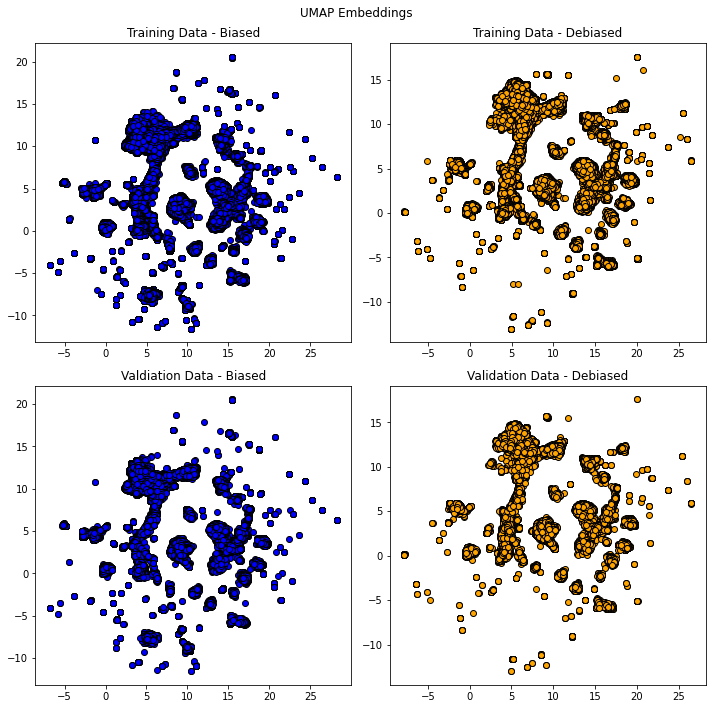

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter(x=emb_umap_train[:cutoff_train,0], y=emb_umap_train[:cutoff_train,1], c="blue", edgecolors='black')
axs[0,0].set_title("Training Data - Biased")
axs[0,1].scatter(x=emb_umap_train[cutoff_train:,0], y=emb_umap_train[cutoff_train:,1], c="orange", edgecolors='black')
axs[0,1].set_title("Training Data - Debiased")
axs[1,0].scatter(x=emb_umap_val[:cutoff_val,0], y=emb_umap_val[:cutoff_val,1], c="blue", edgecolors='black')
axs[1,0].set_title("Valdiation Data - Biased")
axs[1,1].scatter(x=emb_umap_val[cutoff_val:,0], y=emb_umap_val[cutoff_val:,1], c="orange", edgecolors='black')
axs[1,1].set_title("Validation Data - Debiased")
fig.suptitle('UMAP Embeddings')
fig.tight_layout()

In [20]:
# fig, axs = plt.subplots(2, 1, figsize=(10,10))
# c = ["blue" if i in idx else "gainsboro" for i in np.arange(cutoff_train)]
# axs[0].scatter(x=emb_umap_train[:cutoff_train,0], y=emb_umap_train[:cutoff_train,1], c=c, edgecolors='black')
# axs[0].set_title("Training Data - Biased")
# axs[1].scatter(x=emb_umap_train[cutoff_train:,0], y=emb_umap_train[cutoff_train:,1], c=c, edgecolors='black')
# axs[1].set_title("Training Data - Debiased")

In [21]:
distances = torch.norm(emb_train_biased - emb_train_debiased, dim=1)

In [22]:
v, idx = torch.topk(distances, k=10)

In [23]:
dicts = [data_dicts_train[i] for i in idx]

In [24]:
# [(d["title"], d["gender"], d["bio"]) for d in dicts]

In [28]:
sh

torch.Size([235045, 256])

In [29]:
sh = emb_train_biased.shape[1]
linear_transform = torch.nn.Linear(sh,sh)
loss = torch.nn.MSELoss(reduction="none")
opt = torch.optim.SGD(linear_transform.parameters(), lr=1e-4)

In [30]:
ds = TensorDataset(emb_train_biased, emb_train_debiased)
loader = DataLoader(ds, shuffle=True, batch_size=32, drop_last=False)

In [41]:
linear_transform.train()
s = "loss: {:.2f}"
losses = []
train_iterator = trange(20, desc=s.format(math.nan), position=0, leave=False)
for epoch in train_iterator:
    l_list = []
    for x,y in tqdm(loader, position=1, leave=False):
        y_hat = linear_transform(x)
        l = loss(y_hat, y)
        l.mean().backward()
        opt.step()
        opt.zero_grad()
        l_list.append(l.sum(1).detach())
    avg_loss = torch.cat(l_list).mean()
    losses.append(avg_loss)
    train_iterator.set_description(s.format(avg_loss), refresh=True)

loss: nan:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

  0%|          | 0/7346 [00:00<?, ?it/s]

In [42]:
avg_loss

tensor(11.1874)